# Features Exploration & Selection

## Libraries

In [33]:
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (12, 5)
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.5
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

blue_colors = [
    "#D9EDFF",
    "#C1E2FF",
    "#A8D5FF",
    "#8AC6FF",
    "#6BB6FF",
    "#4A9EE5",
    "#2E86DE",
    "#0066C0",
    "#0055A5",
    "#003D82"
]

## Functions

In [34]:
def histogram(probabilities: np.array, y_test: np.array) -> None:
    """
    Plot the probability density of the predicted probabilities for the correct class.

    Parameters:
        probabilities: numpy array of shape (n_samples, n_classes) containing predicted probabilities.
        y_test: numpy array of shape (n_samples,) containing true class labels.
    """
    plt.figure()
    color_idx = [1, 5, 9]
    for class_idx in range(3):
        sns.kdeplot(
            probabilities[y_test == class_idx, class_idx],
            color=blue_colors[color_idx[class_idx]],
            fill=True,
            alpha=0.3,
            linewidth=2,
            label=f"Class {class_idx}"
        )

    plt.title("Probability Density (Correct Class)")
    plt.xlabel("Predicted Probability")
    plt.ylabel("Density")
    plt.legend()
    plt.show()


def importance(features: list, importances: list, n_var: int, importance_type: str) -> None:
    """
    Plot the feature importance based on the provided importances.

    Parameters:
        features: list of feature names.
        importances: list or array of feature importance values.
        n_var: number of top variables to display.
        importance_type: string indicating the type of importance (e.g., 'gain', 'weight').
    """
    model_importance = pd.DataFrame({
        'Variable': features,
        'Importance': importances
    })
    model_importance = model_importance.sort_values(
        by='Importance', ascending=False).head(n_var)

    cmap = LinearSegmentedColormap.from_list(
        "custom_coolwarm", [blue_colors[-1], blue_colors[0]])
    custom_palette = sns.color_palette(
        [cmap(i) for i in np.linspace(0, 1, len(model_importance))])

    plt.figure()
    sns.barplot(x="Importance", y="Variable",
                data=model_importance, palette=custom_palette)
    for index, value in enumerate(model_importance["Importance"]):
        plt.text(value - 0.001, index, f"{value:.2f}", va="center", ha='right')
    plt.xlabel('Importance')
    plt.xlim(0, max(model_importance["Importance"]) * 1.05)
    plt.ylabel('Variables')
    plt.title(f'{n_var} most important variables ({importance_type}-type)')
    plt.show()


def shap_plot(X_test: pd.DataFrame, model: XGBClassifier, n_var: int) -> np.array:
    """
    Plot SHAP summary plots for the given model and test data.

    Parameters:
        X_test: pandas DataFrame containing the test features.
        model: trained XGBoost model (XGBClassifier) for which SHAP values are to be computed.
        n_var: number of top variables to display in the SHAP summary plots.

    Returns:
        shap_values: numpy array containing the SHAP values for the test data.
    """
    X_shap = X_test.sample(int(len(X_test) * 0.8), random_state=42)

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_shap)

    plt.figure()
    shap.summary_plot(shap_values, X_shap, plot_type="bar",
                      max_display=n_var, show=False)
    plt.title("SHAP Summary Bar Plot - All Classes")
    plt.show()

    n_classes = shap_values.shape[2]

    for class_idx in range(n_classes):

        plt.figure()
        shap.summary_plot(
            shap_values[:, :, class_idx],
            X_shap,
            plot_type="bar",
            max_display=n_var,
            show=False
        )
        plt.title(f"SHAP Summary Bar Plot - Class {class_idx}")
        plt.show()

        plt.figure()
        shap.summary_plot(
            shap_values[:, :, class_idx],
            X_shap,
            plot_type="dot",
            max_display=n_var,
            show=False
        )

        plt.title(f"SHAP Summary Dot Plot - Class {class_idx}")
        plt.show()

    return shap_values

## Classification Model

In [35]:
def xgboost(X_train: pd.DataFrame, X_test: pd.DataFrame, y_train: pd.Series, y_test: pd.Series) -> tuple[XGBClassifier, np.array]:
    """
    Train an XGBoost classifier and return the model along with predicted probabilities for the test set.

    Parameters:
        X_train: pd.DataFrame containing the training features.
        X_test: pd.DataFrame containing the test features.
        y_train: pd.Series containing the training labels.
        y_test: pd.Series containing the test labels.

    Returns:
        model: trained XGBClassifier model.
        probabilities: numpy array of shape (n_samples, n_classes) containing predicted probabilities for the test set.
    """
    model = XGBClassifier(
        n_estimators=400,
        max_depth=3,
        learning_rate=0.05,
        reg_lambda=1,
        subsample=0.8,
        colsample_bytree=0.8,
        gamma=0,
        tree_method='hist',
        random_state=42
    )
    model.fit(X_train, y_train, eval_set=[
              (X_train, y_train), (X_test, y_test)], verbose=100)

    probabilities = model.predict_proba(X_test)
    return model, probabilities

## Results

In [36]:
df = pd.read_csv('Data/clean_train.csv')

df['Credit_Score'] = df['Credit_Score'].map({
    'Poor': 0,
    'Standard': 1,
    'Good': 2
})

target = 'Credit_Score'
y = df[target]

# Important features for class diferentation
important_features = ['Outstanding_Debt', 'Interest_Rate', 'Delay_from_due_date',       # class 0
                      'Num_Credit_Card', 'Num_of_Delayed_Payment', 'High_spent',        # class 0
                      'Credit_Mix_Standard', 'Changed_Credit_Limit', 'Credit_Mix_Good',  # class 1
                      'Payment_of_Min_Amount_Yes',                                      # class 1
                      'Total_EMI_per_month']                                            # class 2

# droping non-informative and target columns
X = df.drop(columns=["Customer_ID", "ID", "Name", "SSN", "Month", target])
# keeping only important features for class differentiation
X = X.drop(columns=[col for col in X.columns if col not in important_features])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

model, probabilities = xgboost(X_train, X_test, y_train, y_test)

[0]	validation_0-mlogloss:0.98347	validation_1-mlogloss:0.98332
[100]	validation_0-mlogloss:0.68851	validation_1-mlogloss:0.68575
[200]	validation_0-mlogloss:0.67429	validation_1-mlogloss:0.67328
[300]	validation_0-mlogloss:0.66671	validation_1-mlogloss:0.66785
[399]	validation_0-mlogloss:0.66093	validation_1-mlogloss:0.66421


### Probabilities histogram

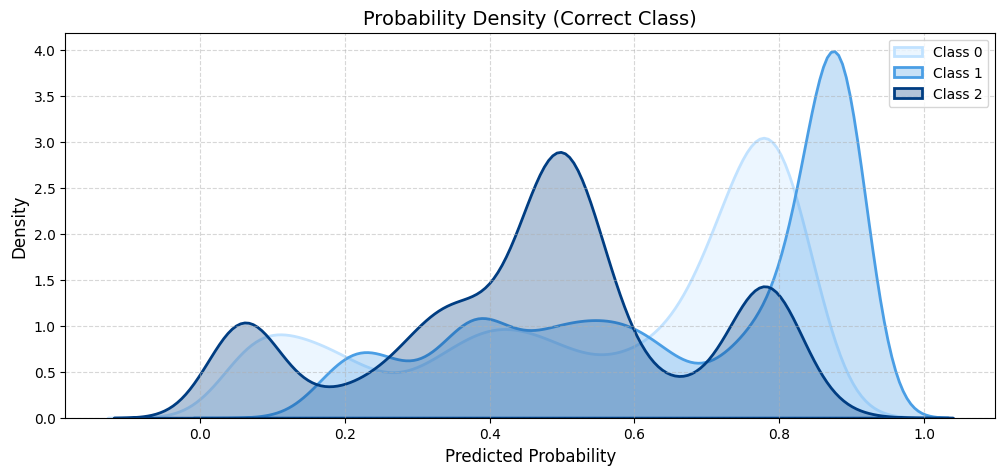

In [37]:
histogram(probabilities, y_test)

### Importances

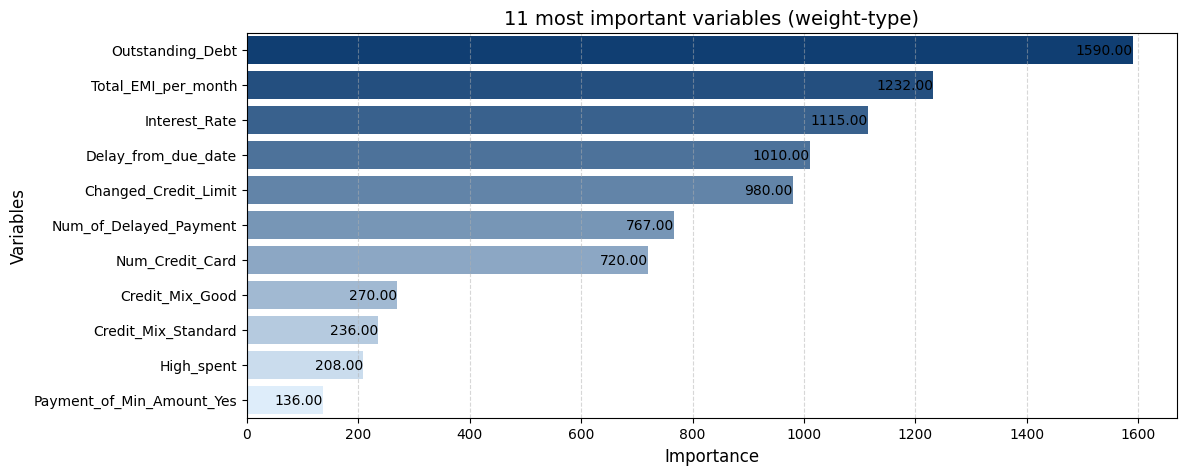

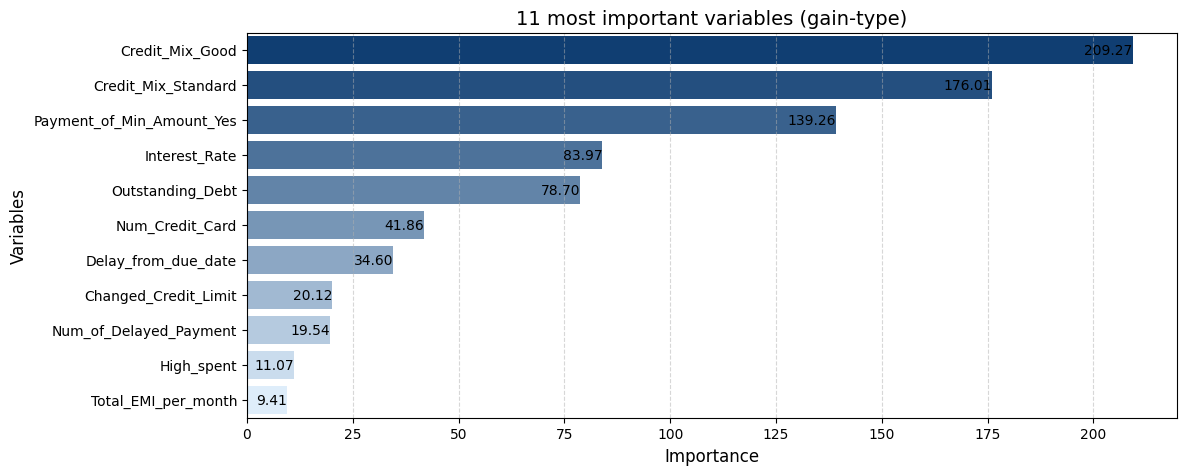

In [38]:
importancia_weight_dict = model.get_booster().get_score(importance_type='weight')
importancia_gain_dict = model.get_booster().get_score(importance_type='gain')

# Separar nombres y valores
features_weight = list(importancia_weight_dict.keys())
valores_weight = list(importancia_weight_dict.values())

features_gain = list(importancia_gain_dict.keys())
valores_gain = list(importancia_gain_dict.values())

importance(features_weight, valores_weight, len(important_features), 'weight')
importance(features_gain, valores_gain, len(important_features), 'gain')

### Shap Values

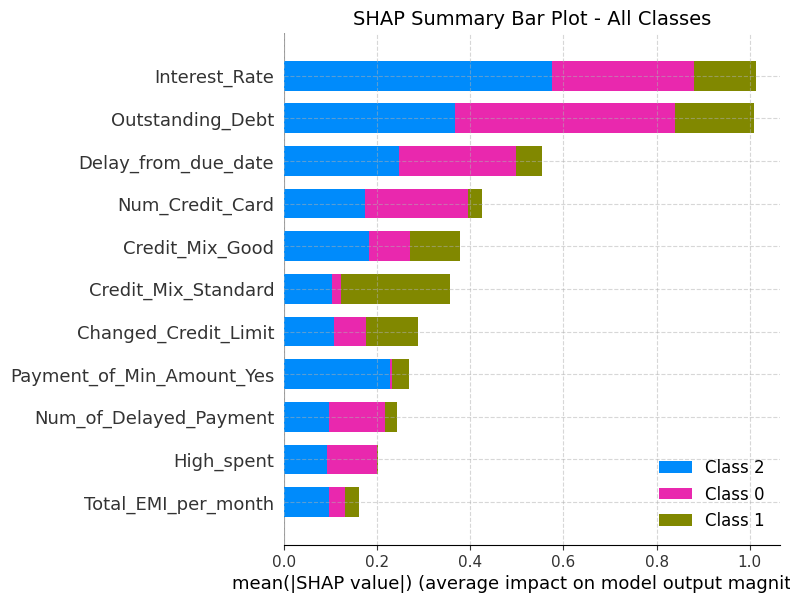

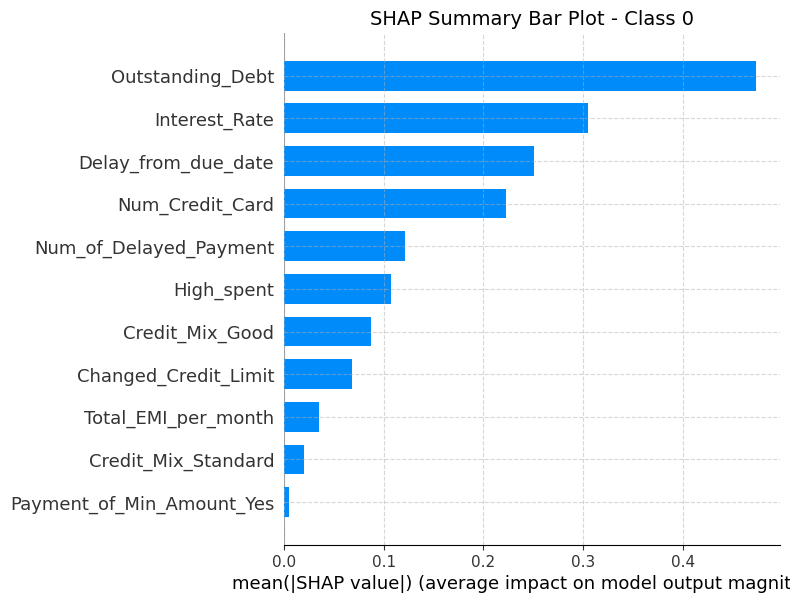

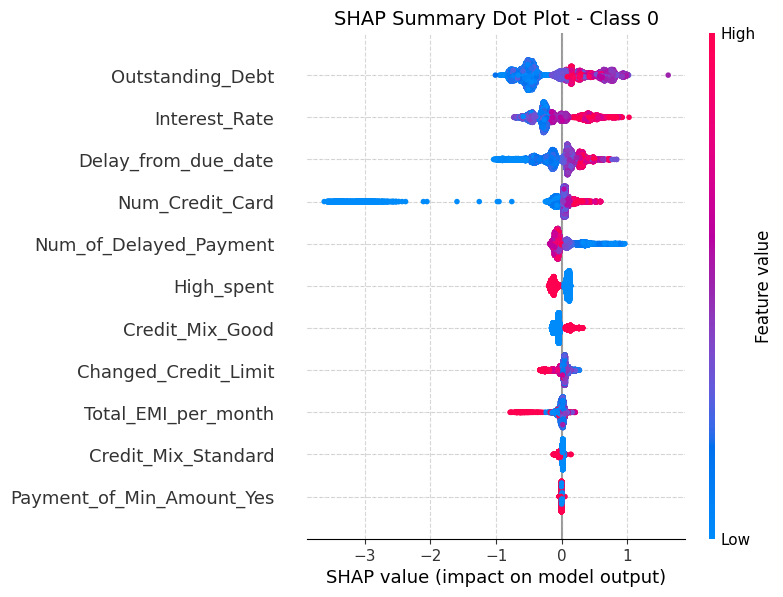

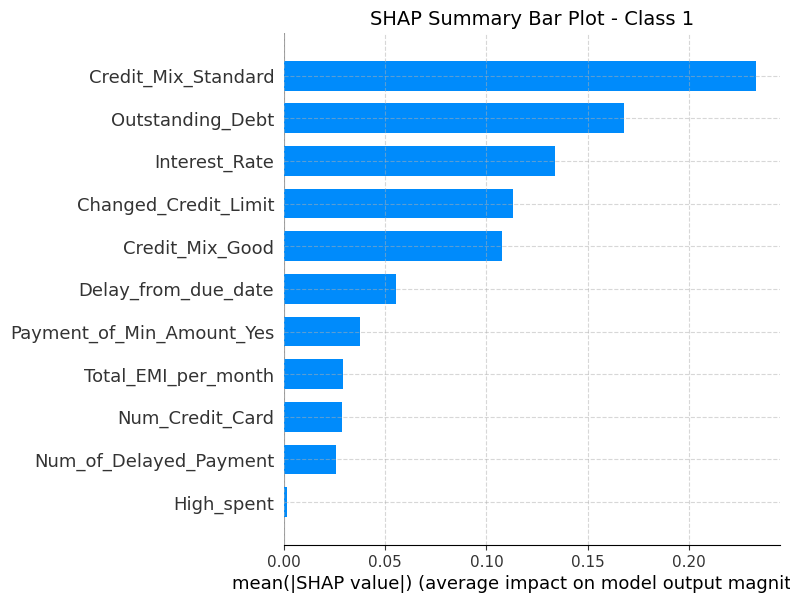

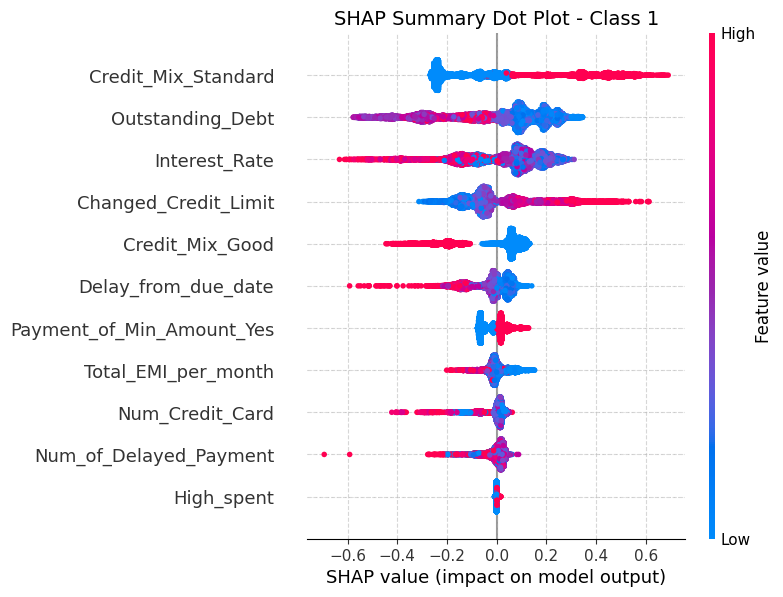

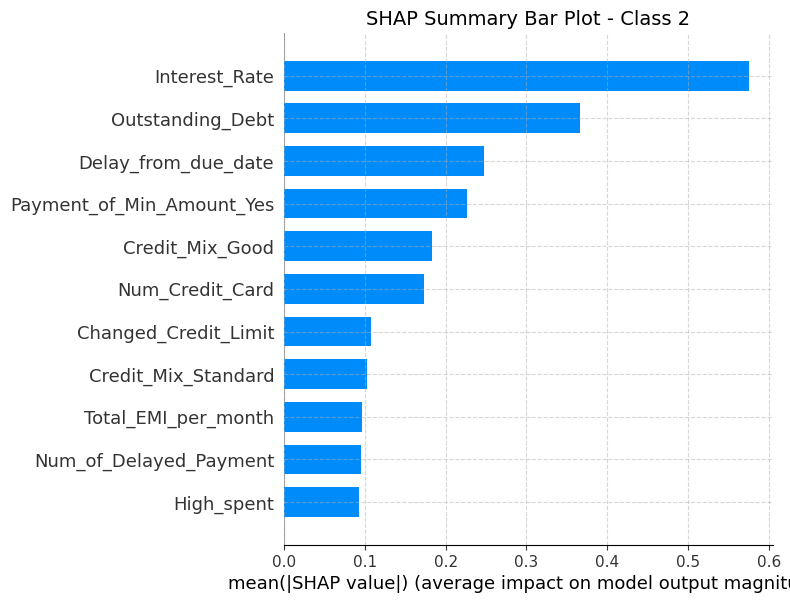

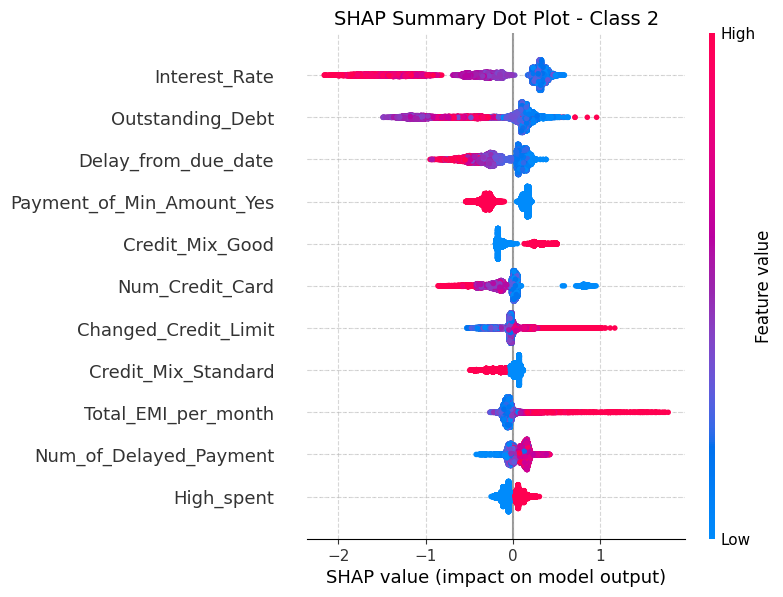

In [39]:
shap_values = shap_plot(X_test, model, len(important_features))

In [40]:
print(X_train.columns, len(X_train.columns))

Index(['Num_Credit_Card', 'Interest_Rate', 'Delay_from_due_date',
       'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Outstanding_Debt',
       'Total_EMI_per_month', 'High_spent', 'Credit_Mix_Good',
       'Credit_Mix_Standard', 'Payment_of_Min_Amount_Yes'],
      dtype='str') 11
